<table class="m01-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/yy/dviz-course/blob/master/docs/m09-estimation/lab09.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a href="https://yyahn.com/dviz-course/m09-estimation/lab09/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on Github</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/yy/dviz-course/master/docs/m09-estimation/lab09.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View raw on Github</a>
  </td>
</table>

# Module 9: Estimation

In this lab, we will learn about Kernel Density Estimation (KDE), interpolation, and (briefly) regression.

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import altair as alt
import pandas as pd
import scipy.stats as ss
%matplotlib inline

## Kernel density estimation

Let's import the IMDb data.

In [93]:
import vega_datasets

movies = vega_datasets.data.movies()
movies.head()

,Title,US_Gross,Worldwide_Gross,US_DVD_Sales,Production_Budget,Release_Date,MPAA_Rating,Running_Time_min,Distributor,Source,Major_Genre,Creative_Type,Director,Rotten_Tomatoes_Rating,IMDB_Rating,IMDB_Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0


Although we have learned that it is dangerous to drop any missing values, we will do so for the sake of simplicity. We are also really not trying to draw any conclusions about the data so it is okay. But be careful with missing data in practice!

**Q: Can you drop rows that have NaN value in either `IMDB_Rating` or `Rotten_Tomatoes_Rating`?**

In [94]:
# YOUR SOLUTION HERE
movies.dropna(subset=['IMDB_Rating', 'Rotten_Tomatoes_Rating'], inplace=True)

We can plot histogram and KDE using pandas:

<Axes: ylabel='Density'>

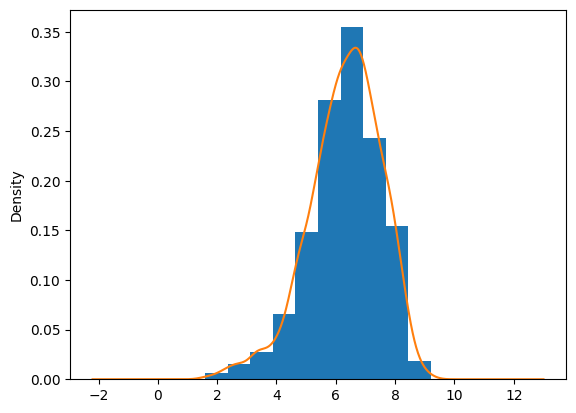

In [95]:
movies['IMDB_Rating'].hist(bins=10, density=True)
movies['IMDB_Rating'].plot(kind='kde')

Or using seaborn (two ways):

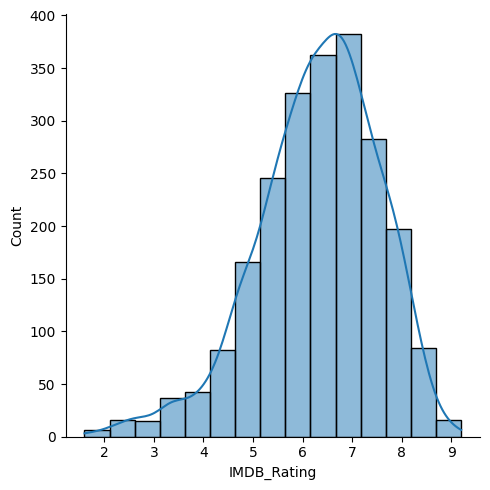

In [96]:
sns.displot(movies['IMDB_Rating'], bins=15, kde=True)

<Axes: xlabel='IMDB_Rating', ylabel='Count'>

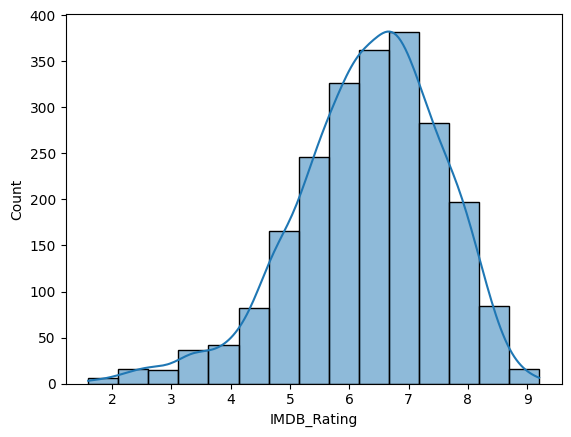

In [97]:
sns.histplot(movies['IMDB_Rating'], bins=15, kde=True)

**Q: Can you plot the histogram and KDE of the `Rotten_Tomatoes_Rating`?**

<Axes: ylabel='Density'>

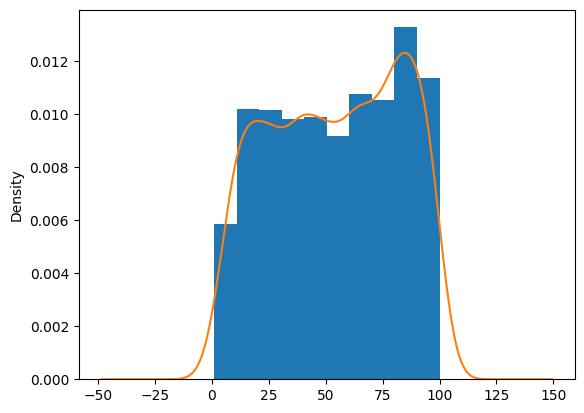

In [98]:
# YOUR SOLUTION HERE
movies['Rotten_Tomatoes_Rating'].hist(bins=10, density=True)
movies['Rotten_Tomatoes_Rating'].plot(kind='kde')

Let's study how KDE changes with the size of the data.

We can get a random sample using the pandas' [**`sample()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) function. The [**`kdeplot()`**](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) function in seaborn provides many options (like kernel types) to do KDE. Let's sample some data points and see how does KDE plot changes with the size of the samples.

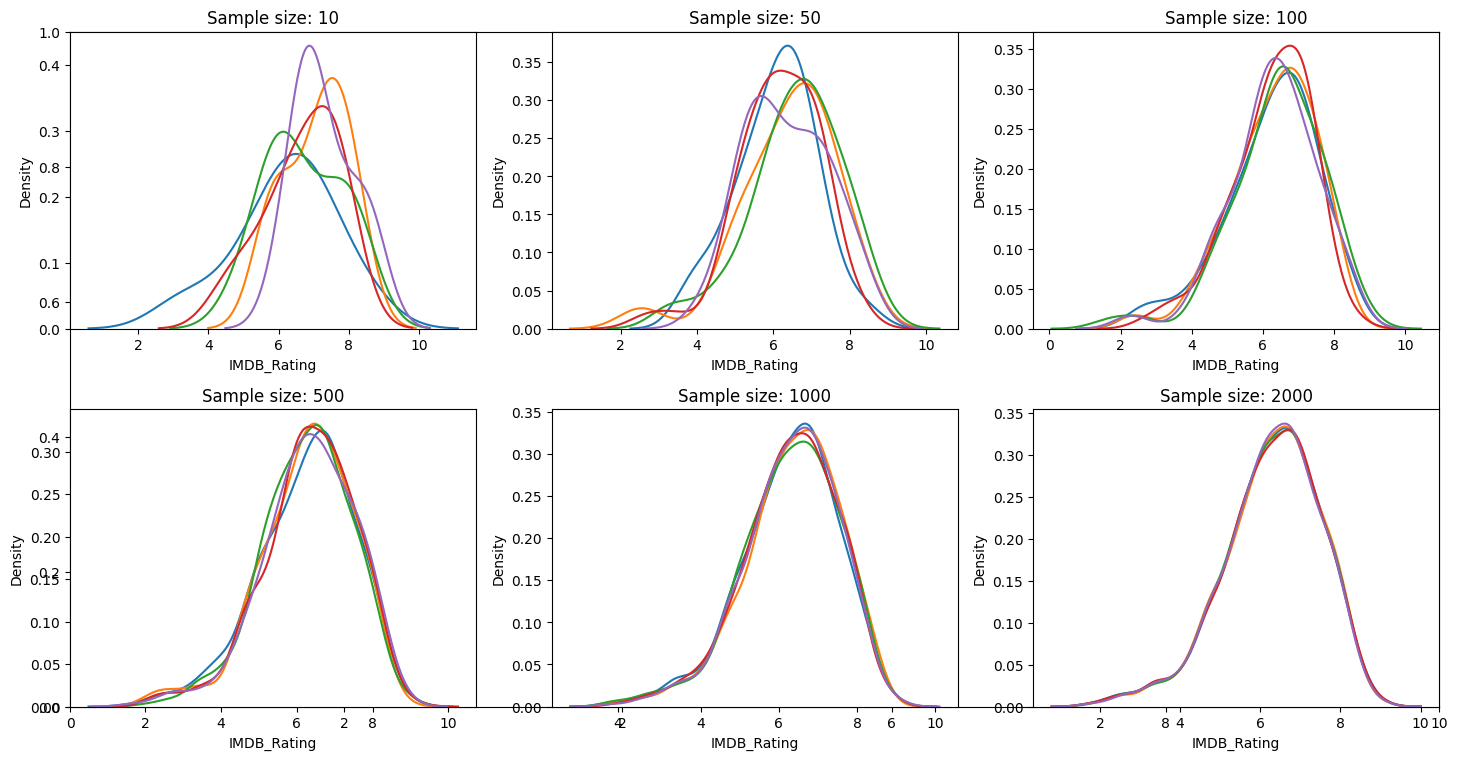

In [99]:
f = plt.figure(figsize=(15,8))
plt.xlim(0, 10)

sample_sizes = [10, 50, 100, 500, 1000, 2000]
for i, N in enumerate(sample_sizes, 1):
    plt.subplot(2,3,i)
    plt.title("Sample size: {}".format(N))
    for j in range(5):
        s = movies['IMDB_Rating'].sample(N)
        sns.kdeplot(s, legend=False)
plt.tight_layout()

We can also draw KDE plots using scikit-learn to change kernel functions.

First, we need points to score across.
- Remember the np.linspace() function?
- IMDB scores are only between 1 and 10. Let's create 1000 points between 1 and 10.

In [100]:
# use the linespace function to create a list of 1000 values
# between 1 and 10
# Store the sequence in a variable called X_vals

# YOUR SOLUTION HERE
X_vals = np.linspace(1, 10, num=1000)
X_vals[0:10]


array([1.        , 1.00900901, 1.01801802, 1.02702703, 1.03603604,
       1.04504505, 1.05405405, 1.06306306, 1.07207207, 1.08108108])

In [101]:
X_vals.shape

(1000,)

Our array needs to have 2 dimensions for score_samples() to work. Let's add another dimension to our array using np.newaxis.

In [102]:
X_plot = X_vals[:, np.newaxis]
X_plot[0:10]

array([[1.        ],
       [1.00900901],
       [1.01801802],
       [1.02702703],
       [1.03603604],
       [1.04504505],
       [1.05405405],
       [1.06306306],
       [1.07207207],
       [1.08108108]])

In [103]:
X_plot.shape

(1000, 1)

The KernelDensity function in scikit-learn needs a 2d array for the samples when we fit to the different kernels.
Multidimensional scaling is deprecated for pandas series. We can cast the series to a numpy array before adding another dimension to solve this issue.

In [104]:
sample = movies['IMDB_Rating'].sample(5)
print(sample)
print(type(sample))
print(sample.shape)

2676    5.9
575     7.7
1890    6.0
1106    7.6
67      5.6
Name: IMDB_Rating, dtype: float64
<class 'pandas.core.series.Series'>
(5,)


In [105]:
sample = np.array(sample)
print(sample)
print(type(sample))
print(sample.shape)

[5.9 7.7 6.  7.6 5.6]
<class 'numpy.ndarray'>
(5,)


In [106]:
# Add another dimension to sample using np.newaxis
# Just like we did to X_vals.

# YOUR SOLUTION HERE
sample = sample[:, np.newaxis]
print(sample)
print(type(sample))
print(sample.shape)

[[5.9]
 [7.7]
 [6. ]
 [7.6]
 [5.6]]
<class 'numpy.ndarray'>
(5, 1)


Now, let's plot using the **`tophat`** and **`gaussian`** kernels using the different sample sizes we used before. We'll do this using scikit-learn's `KernelDensity()` function.

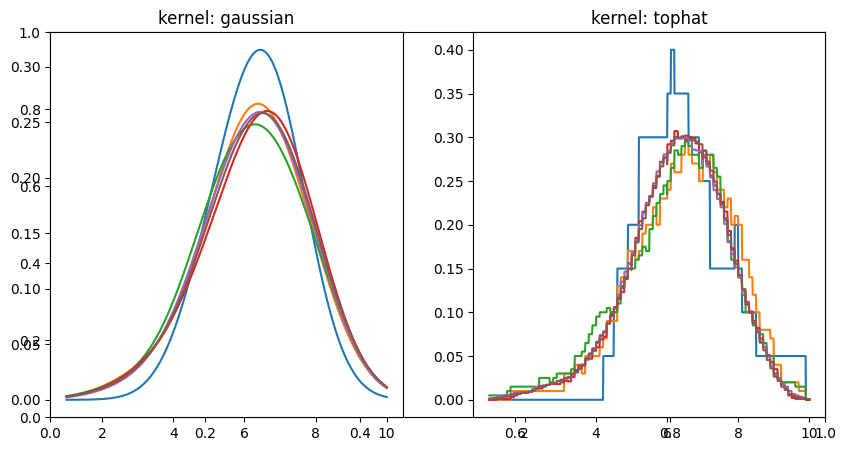

In [107]:
from sklearn.neighbors import KernelDensity
sample_sizes = [10, 50, 100, 500, 1000, 2000]

def plot_kde(X_plot, sample_sizes, movies, kernel='gaussian'):
    for sample_size in sample_sizes:
        sample = np.array(movies['IMDB_Rating'].sample(sample_size))
        sample = sample[:, np.newaxis]
        kde = KernelDensity(kernel=kernel).fit(sample)
        log_density = kde.score_samples(X_plot)
        plt.plot(X_plot[:, 0], np.exp(log_density), '-')

fig, ax = plt.subplots(figsize=(10,5))

# Let's look at the gaussian kernel like before
# put it in the first spot on a 1x2 grid
plt.subplot(1,2,1)
plt.title("kernel: {}".format('gaussian'))
plot_kde(X_plot, sample_sizes, movies)
# Now let's look at the tophat kernel
# put it in the second spot on a 1x2 grid
plt.subplot(1,2,2)
plt.title("kernel: {}".format('tophat'))
plot_kde(X_plot, sample_sizes, movies, kernel='tophat')

Let's try all kernel types using scikit-learn's `KernelDensity()`. Plot a 2x3 grid, however, instead of changing sample sizes like above, make each plot use the 6 different kernels supported by scikit-learn.
Keep the sample size to 2 so we can more easily see the different distribution shapes. Also, draw a different sample (of 2) 5 times like the plots we drew with seaborn above.

Helpful links:

* https://scikit-learn.org/stable/modules/density.html

* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity

* https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

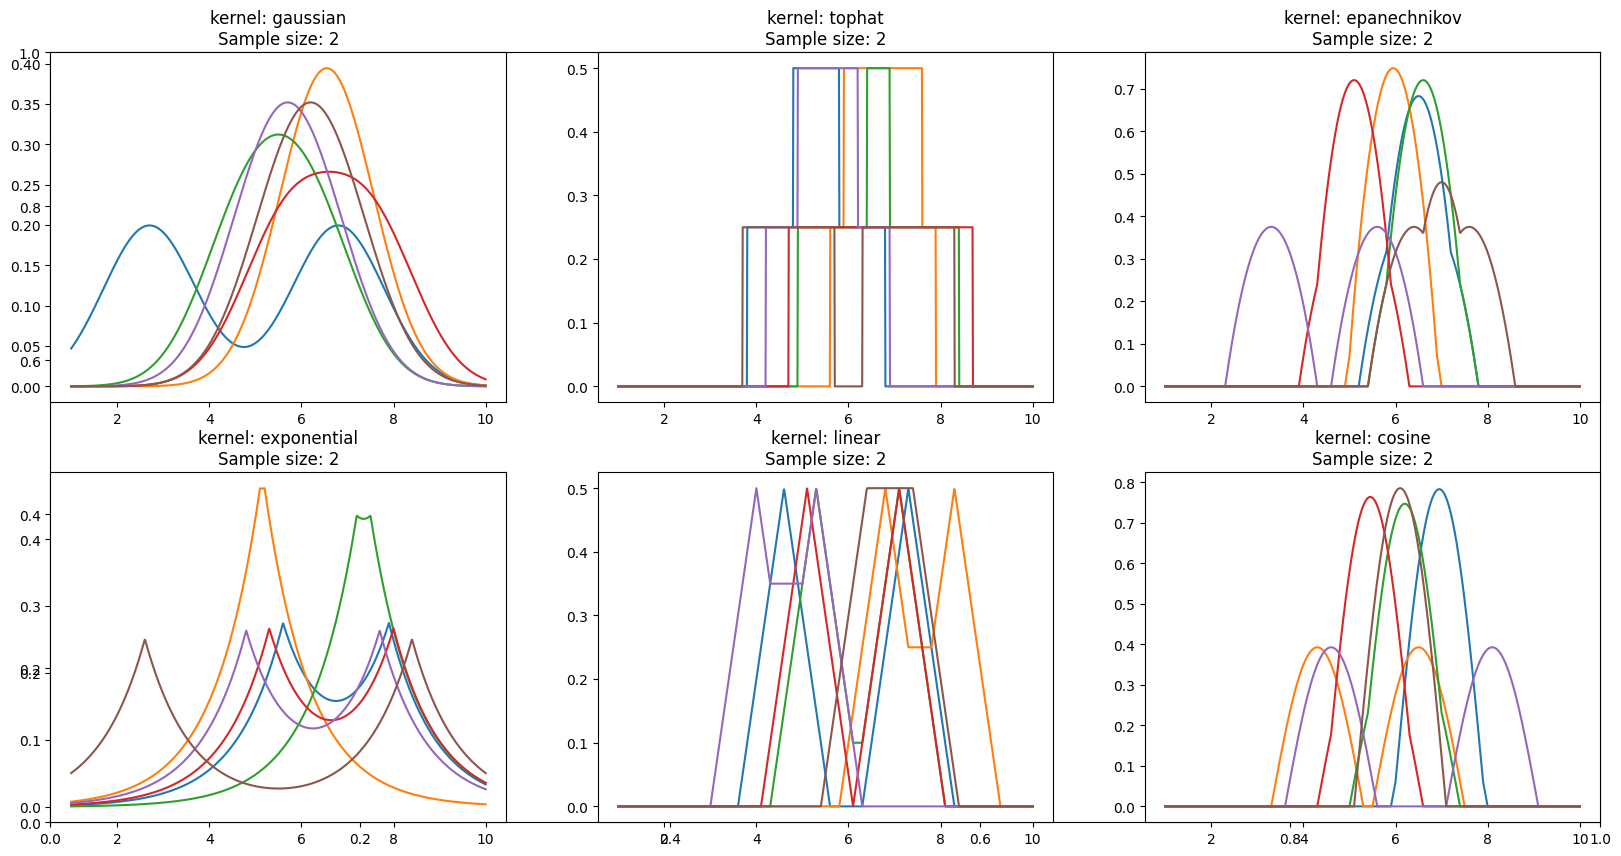

In [108]:
# YOUR SOLUTION HERE
sample_sizes = [2, 2, 2, 2, 2, 2]

fig, ax = plt.subplots(figsize=(20,10))

plt.subplot(2,3,1)
plt.title("kernel: {}\nSample size: 2".format('gaussian'))
plot_kde(X_plot, sample_sizes, movies)

plt.subplot(2,3,2)
plt.title("kernel: {}\nSample size: 2".format('tophat'))
plot_kde(X_plot, sample_sizes, movies, kernel='tophat')

plt.subplot(2,3,3)
plt.title("kernel: {}\nSample size: 2".format('epanechnikov'))
plot_kde(X_plot, sample_sizes, movies, kernel='epanechnikov')

plt.subplot(2,3,4)
plt.title("kernel: {}\nSample size: 2".format('exponential'))
plot_kde(X_plot, sample_sizes, movies, kernel='exponential')

plt.subplot(2,3,5)
plt.title("kernel: {}\nSample size: 2".format('linear'))
plot_kde(X_plot, sample_sizes, movies, kernel='linear')

plt.subplot(2,3,6)
plt.title("kernel: {}\nSample size: 2".format('cosine'))
plot_kde(X_plot, sample_sizes, movies, kernel='cosine')

**Q: Let's use Seaborn again. We can play with the bandwidth option. Make sure to set the `xlim` so that all plots have the same x range, so that we can compare.**

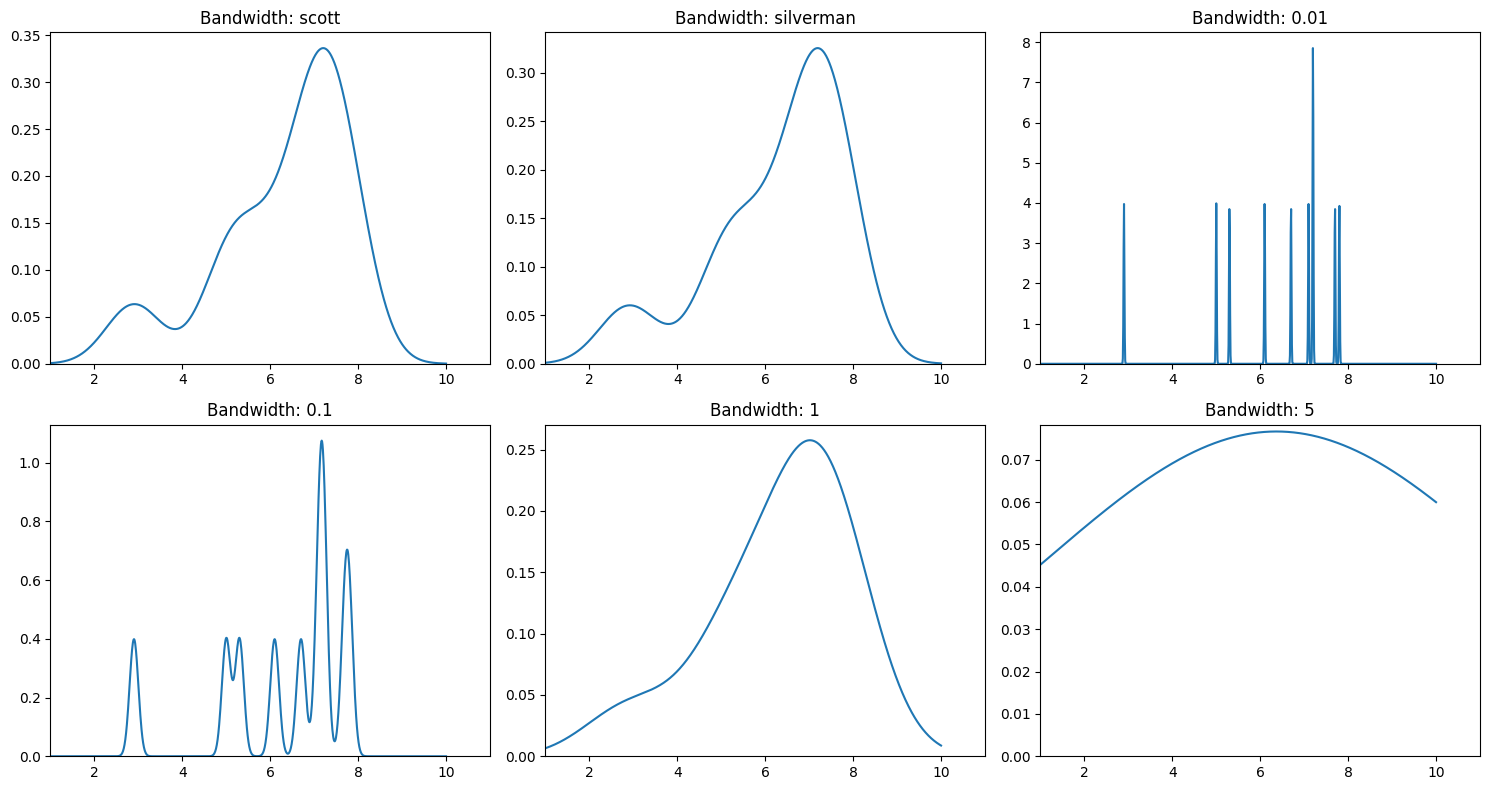

In [109]:
f = plt.figure(figsize=(15,8))
bw = ['scott', 'silverman', 0.01, 0.1, 1, 5]
sample_size = 10
sample = np.array(movies['IMDB_Rating'].sample(sample_size))

# YOUR SOLUTION HERE
for i, b in enumerate(bw, 1):
    ax = f.add_subplot(2, 3, i)
    kde = KernelDensity(bandwidth=b)

    kde.fit(sample[:, np.newaxis])
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-')
    ax.set_title(f"Bandwidth: {b}")

    top = ax.get_ylim()[1]
    ax.set_xlim(1, 11)
    ax.set_ylim(0, top)

plt.tight_layout()

**Q: What's your takeaway? Explain how bandwidth affects the result of your visualization.**

# YOUR SOLUTION HERE
If the bandwidth is too low, the kernel functions on each point seem to not overlap, with too many spiky peaks, meaning overfitting; on the contrary, if the bandwidth is too high, the data will lose its feature details, with only one peak.
Generally, Scott or Silverman method works well than setting the bandwidth artificially.

## Interpolation

One area where interpolation is used a lot is image processing. Play with it!

https://matplotlib.org/examples/images_contours_and_fields/interpolation_methods.html

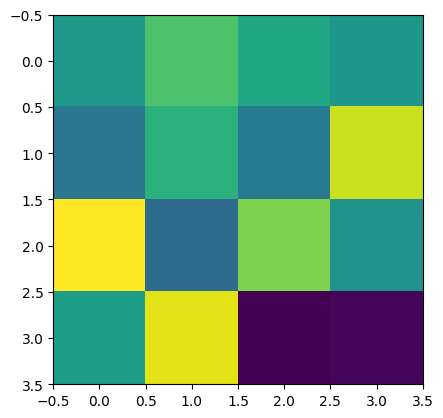

In [110]:
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
np.random.seed(0)
grid = np.random.rand(4, 4)

plt.imshow(grid, interpolation=None, cmap='viridis')

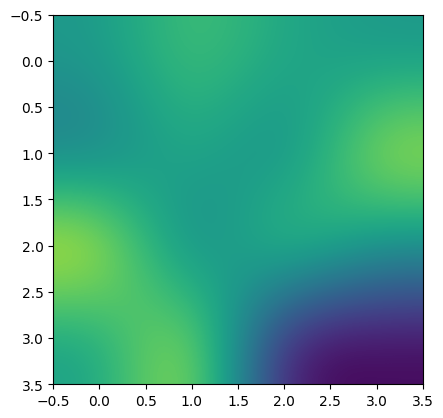

In [111]:
plt.imshow(grid, interpolation='bicubic', cmap='viridis')

Let's look at some time series data.

In [112]:
co2 = vega_datasets.data.co2_concentration()
co2.head()

,Date,CO2
0,1958-03-01,315.70
1,1958-04-01,317.46
2,1958-05-01,317.51
3,1958-07-01,315.86
4,1958-08-01,314.93


In [113]:
co2.Date.dtype

dtype('O')

The `Date` colume is stored as strings. Let's convert it to `datetime` so that we can manipulate.

In [114]:
pd.to_datetime(co2.Date).head()

0   1958-03-01
1   1958-04-01
2   1958-05-01
3   1958-07-01
4   1958-08-01
Name: Date, dtype: datetime64[ns]

In [115]:
co2.Date = pd.to_datetime(co2.Date)

In [116]:
co2.set_index('Date', inplace=True)
co2.head()

,CO2
Date,
1958-03-01,315.70
1958-04-01,317.46
1958-05-01,317.51
1958-07-01,315.86
1958-08-01,314.93


<Axes: xlabel='Date'>

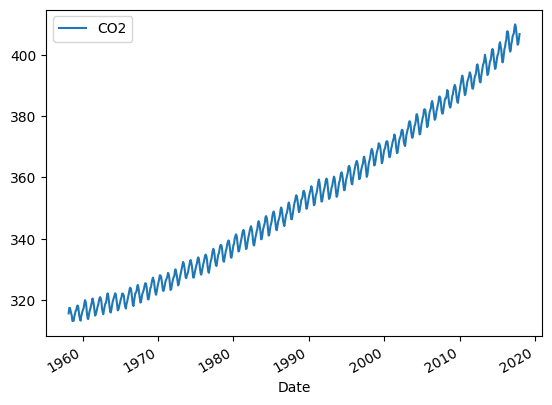

In [117]:
co2.plot()

😢

In [118]:
recent_co2 = co2.tail(8)

<Axes: xlabel='Date'>

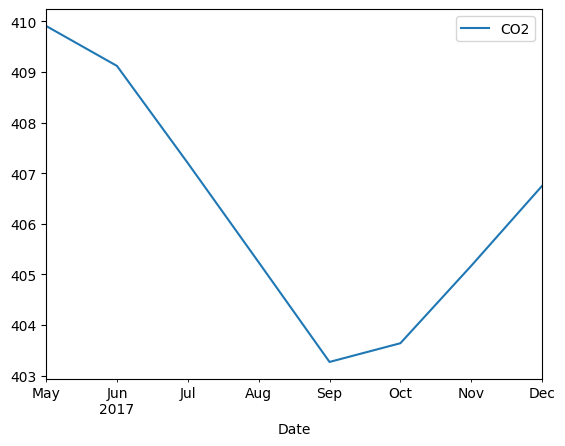

In [119]:
recent_co2.plot()

This standard line chart above can be considered as a chart with linear interpolation between data points.

The data contains measurements at the resolution of about a month. Let's up-sample the data. This process create new rows that fill the gap between data points. We can use `interpolate()` function to fill the gaps.

In [120]:
upsampled = recent_co2.resample('D')
upsampled.interpolate().head()

,CO2
Date,
2017-05-01,409.910000
2017-05-02,409.884516
2017-05-03,409.859032
2017-05-04,409.833548
2017-05-05,409.808065


If we do `linear` interpolation, we get more or less the same plot, but just with more points.

<Axes: xlabel='Date'>

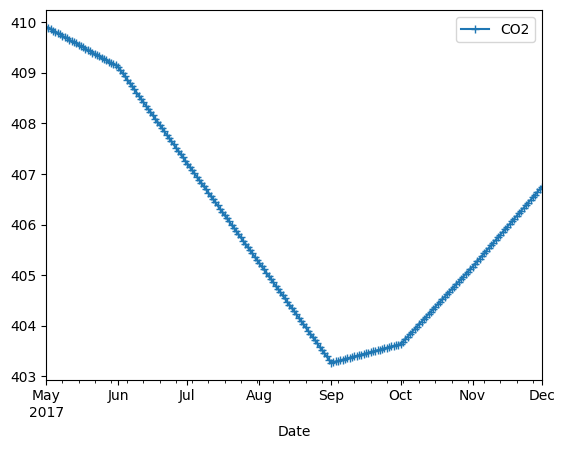

In [121]:
recent_co2.resample('D').interpolate(method='linear').plot(style='+-')

<Axes: xlabel='Date'>

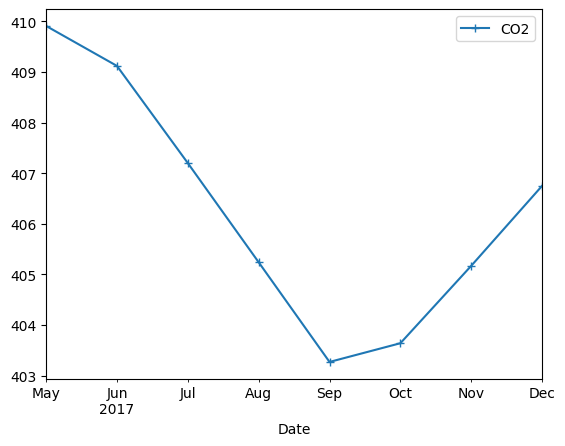

In [122]:
recent_co2.plot(style='+-')

`Nearest` interpolation is just a process of assigning the nearest value to each missing rows.

<Axes: xlabel='Date'>

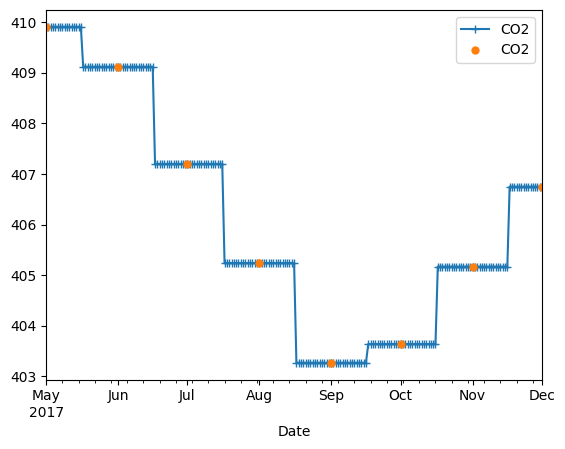

In [123]:
ax = recent_co2.resample('D').interpolate(method='nearest').plot(style='+-')
recent_co2.plot(ax=ax, style='o', ms=5)

Let's try a spline too.

<Axes: xlabel='Date'>

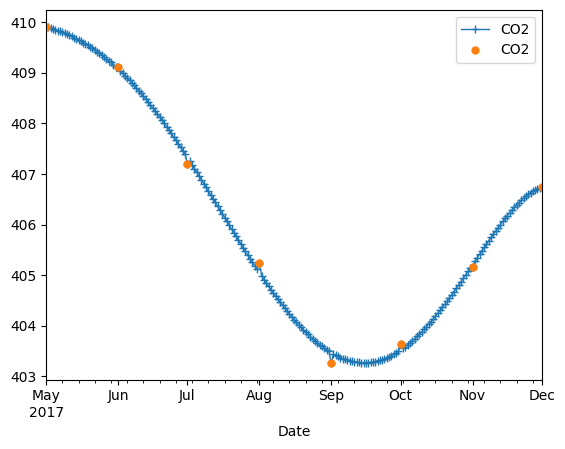

In [124]:
ax = recent_co2.resample('D').interpolate(method='spline', order=5).plot(style='+-', lw=1)
recent_co2.plot(ax=ax, style='o', ms=5)

## Moving average

Pandas has a nice method called `rolling()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

It lets you do operations on the `rolling` windows. For instance, if you want to calculate the moving average, you can simply

<Axes: xlabel='Date'>

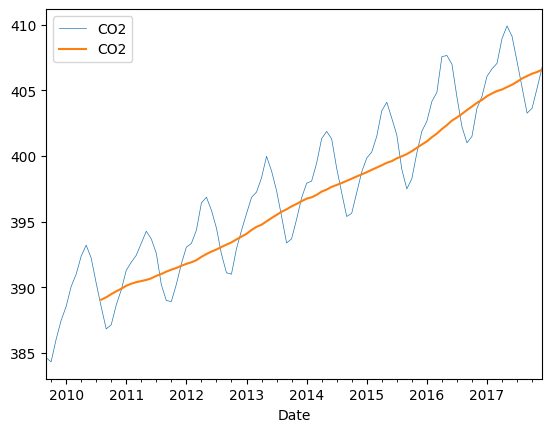

In [125]:
ax = co2[-100:].plot(lw=0.5)
co2[-100:].rolling(12).mean().plot(ax=ax)

By default, it consider every data point inside each window equally (`win_type=None`) but there are many window types supported by `scipy`. Also by default, the mean value is put at the right end of the window (trailing average).  

**Q: can you create a plot with `triang` window type and centered average?**

<Axes: xlabel='Date'>

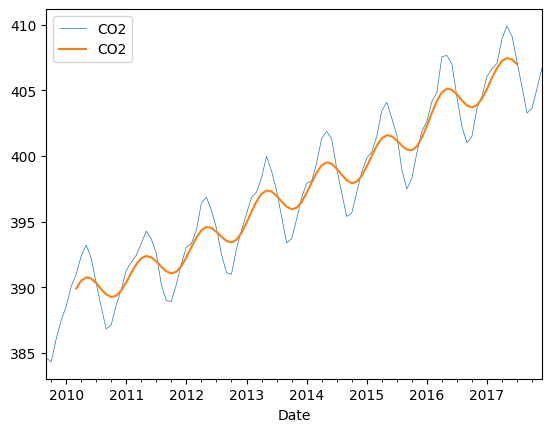

In [135]:
# YOUR SOLUTION HERE
ax = co2[-100:].plot(lw=0.5)
co2[-100:].rolling(12, win_type='triang', center=True).mean().plot(ax=ax)

# Examining relationsips

Remember [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)? Actually, the dataset is not only included in `vega_datasets` but also in `seaborn`.


In [137]:
df = sns.load_dataset("anscombe")
df.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


All four datasets are in this single data frame and the 'dataset' indicator is one of the columns. This is a form often called [tidy data](http://vita.had.co.nz/papers/tidy-data.pdf), which is easy to manipulate and plot. In tidy data, each row is an observation and columns are the properties of the observation. Seaborn makes use of the tidy form. Using seaborn's `lmplot`, you can very quickly examine relationships between variables, separated by some facets of the dataset.

**Q: Can you produce the plot below using `lmplot()`?**

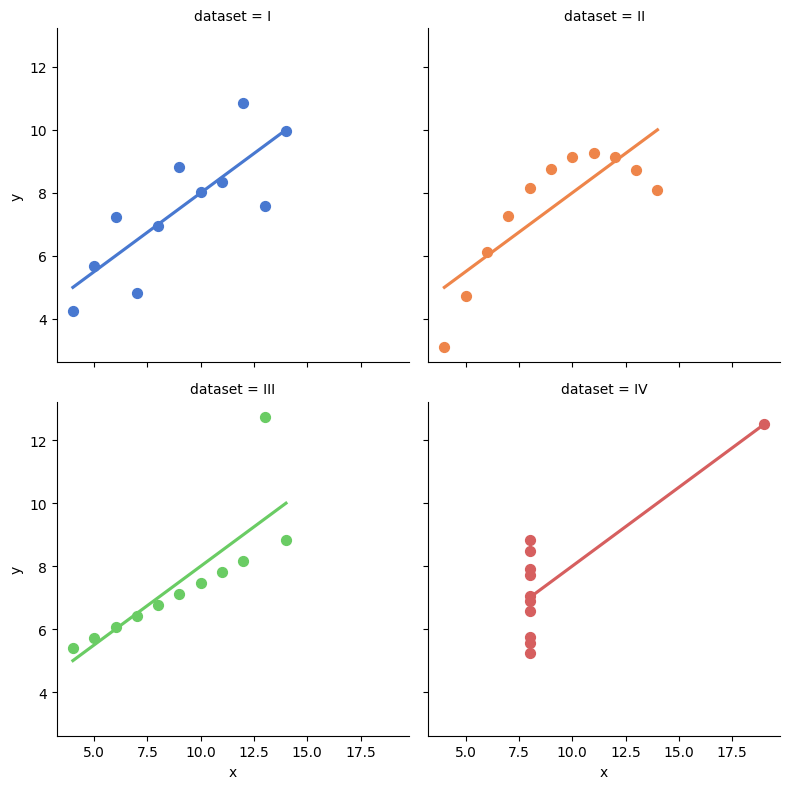

In [138]:
# plotting parameters you can use
palette = "muted"
scatter_kws={"s": 50, "alpha": 1}
ci=None
height=4

# Implement
sns.lmplot(
    data=df,
    x = 'x',
    y = 'y',
    col = 'dataset',
    hue = 'dataset',
    col_wrap=2,
    palette=palette,
    scatter_kws=scatter_kws,
    ci=ci,
    height=height
)

# YOUR SOLUTION HERE

**Q: So let's look at the relationship between `IMDB_Rating` and `Rotten_Tomatoes_Rating` in the `movies` dataset, separated with respect to `MPAA_Rating`. Put 4 plots in a row.**

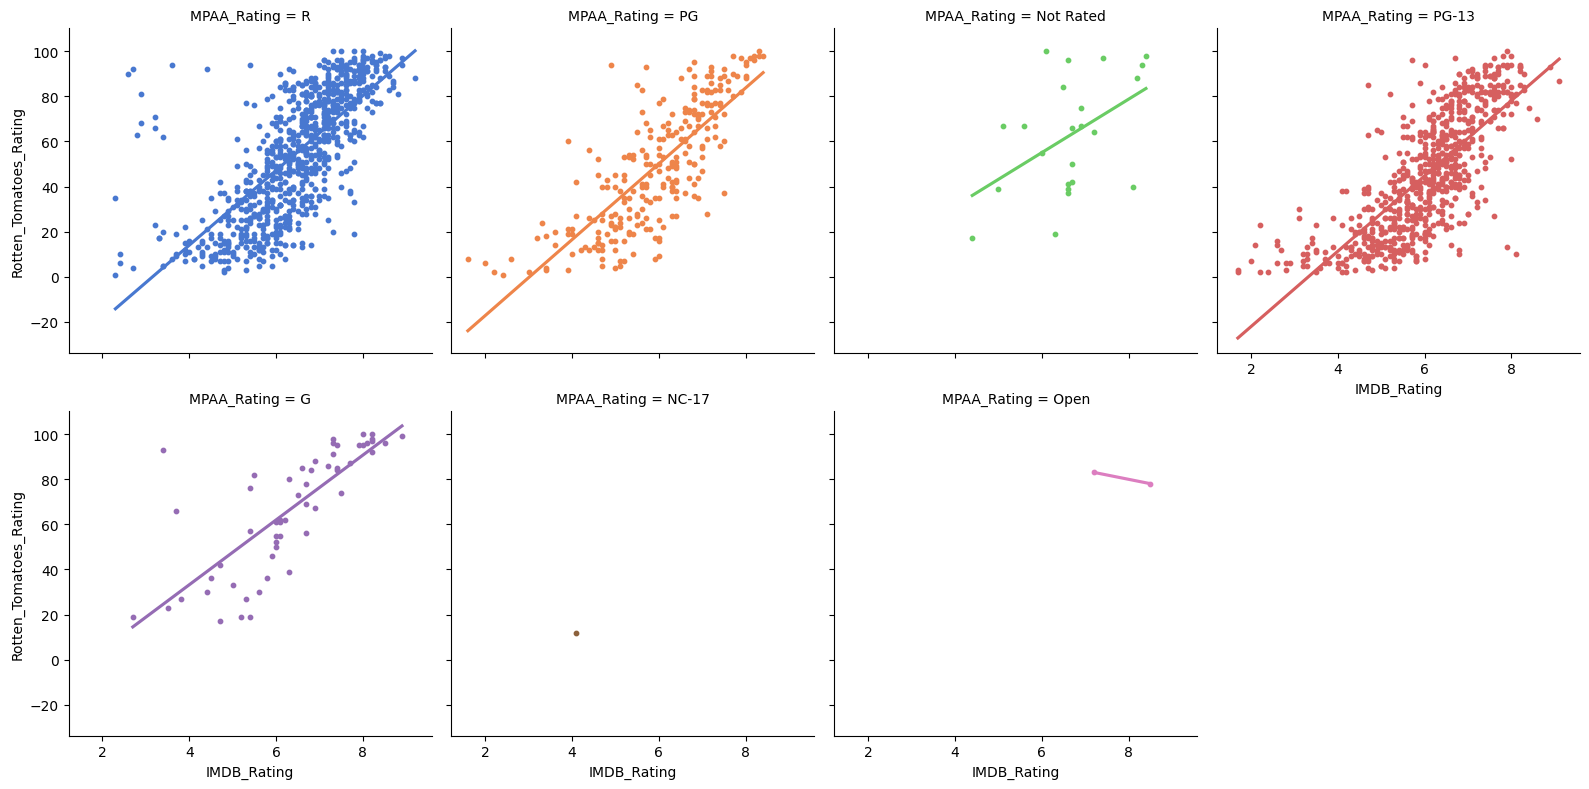

In [143]:

# YOUR SOLUTION HERE
palette = "muted"
scatter_kws={"s": 10, "alpha": 1}
ci=None
height=4
col='MPAA_Rating'
col_wrap=4
data=movies[['IMDB_Rating', 'Rotten_Tomatoes_Rating', 'MPAA_Rating']]

sns.lmplot(
    data=data,
    x="IMDB_Rating", 
    y="Rotten_Tomatoes_Rating",
    col=col,
    hue=col,
    col_wrap=col_wrap,
    palette=palette,
    scatter_kws=scatter_kws,
    ci=ci,
    height=height
)

It may be interesting to dig up what are the movies that have super high Rotten Tomatoes rating and super low IMDB rating (and vice versa)!

Another useful method for examining relationships is [**`jointplot()`**](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html), which produces a scatter plot with two marginal histograms.

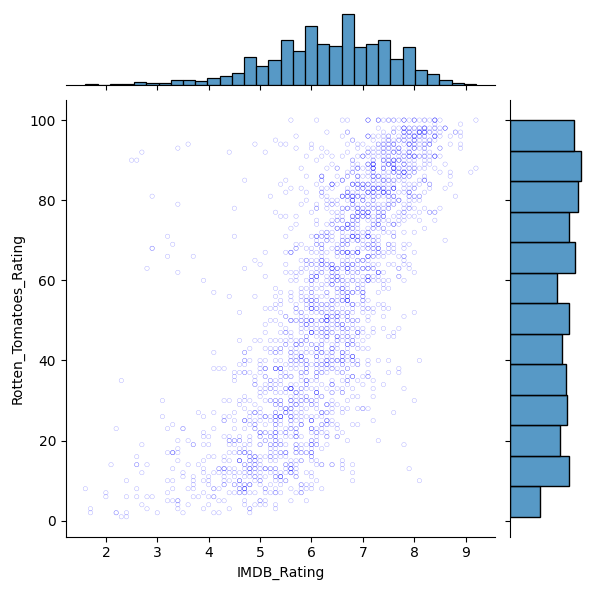

In [144]:
g = sns.jointplot(x = movies['IMDB_Rating'], y = movies['Rotten_Tomatoes_Rating'], s=10, alpha=0.4, facecolors='none', edgecolor='b')

## Hexbin density plot

In 2D, *heatmap* can be considered as a color-based histogram. You divide the space into bins and show the frequency with colors. A common binning method is the hexagonal bin.

We can again use the [**`jointplot()`**](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html) and setting the `kind` to be `hexbin`.

**Q: Can you create one?**

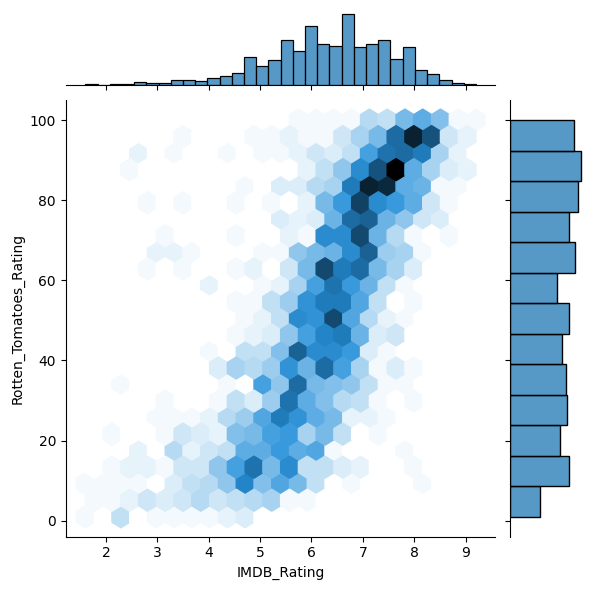

In [146]:
# YOUR SOLUTION HERE
data=movies[['IMDB_Rating', 'Rotten_Tomatoes_Rating']]
sns.jointplot(
    data=data,
    x='IMDB_Rating',
    y='Rotten_Tomatoes_Rating',
    kind='hex'
)

## 2D KDE

We can also do 2D KDE using seaborn's [**`kdeplot()`**](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html) function.

**Q: Can you draw one like this?**

<Axes: xlabel='IMDB_Rating', ylabel='Rotten_Tomatoes_Rating'>

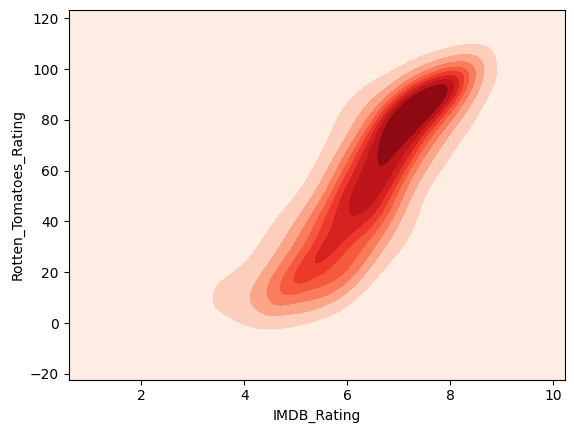

In [147]:
cmap = "Reds"
fill = True         # what happens if you change this?
thresh = 0        # what happens if you change this?

# YOUR SOLUTION HERE
sns.kdeplot(
    data=data,
    x='IMDB_Rating',
    y='Rotten_Tomatoes_Rating',
    cmap=cmap,
    fill=fill,
    thresh=thresh
)

<Axes: xlabel='IMDB_Rating', ylabel='Rotten_Tomatoes_Rating'>

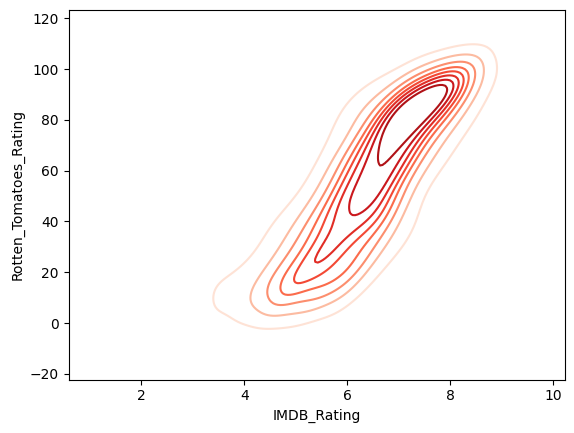

In [148]:
# Test 1: If fill is set as False...
sns.kdeplot(
    data=data,
    x='IMDB_Rating',
    y='Rotten_Tomatoes_Rating',
    cmap=cmap,
    fill=False,
    thresh=thresh
)

<Axes: xlabel='IMDB_Rating', ylabel='Rotten_Tomatoes_Rating'>

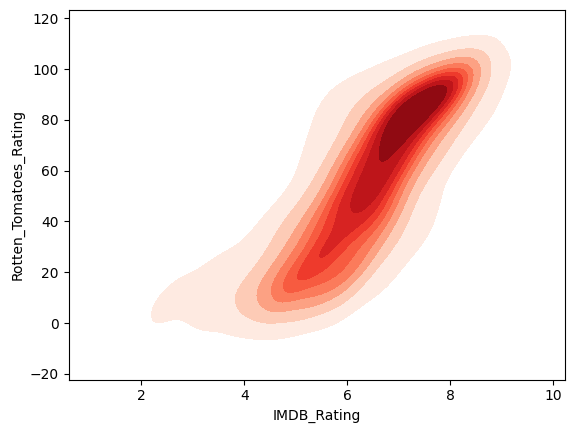

In [149]:
# Test 2: If thresh is modified into another non-zero value...
sns.kdeplot(
    data=data,
    x='IMDB_Rating',
    y='Rotten_Tomatoes_Rating',
    cmap=cmap,
    fill=fill,
    thresh=0.05
)

Or again using [**`jointplot()`**](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html) by setting the `kind` parameter. Look, we also have the 1D marginal KDE plots!

**Q: create jointplot with KDE**

Note that the X-axis is logarithm of `IMDB_Votes`.

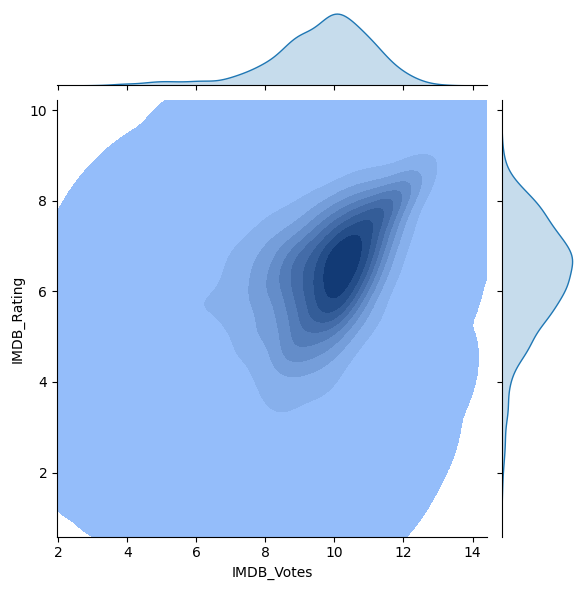

In [162]:
x = np.log(movies['IMDB_Votes'])

# YOUR SOLUTION HERE
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("personal_blues", ["#99c2ff", "#08306b"])


y = movies['IMDB_Rating']
sns.jointplot(
    x=x,
    y=y,
    kind='kde',
    fill=True,
    cmap=cmap,
    thresh=0
)